# Ethical reflections on data science 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Exercise 1

For this exercise, we will use the `adult` dataset (available on moodle or from the [UCI Machine Learning repository](https://archive.ics.uci.edu/dataset/2/adult)). Do the following:

1. Load in the dataset and correct the error in the income column (replace the "." with the empty string such that there are only two categories).
2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)
3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)
4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.
5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.
6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.
7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)
8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.
9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)
10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?
11. Is there predictive parity across different genders?
12. Is there Statistical parity across different genders?
13. [Discussion question] Can your any of your models be used to make fair salary predictions?
14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?

In [45]:
df = pd.read_csv('adult.csv')

In [46]:
df['income'] = df['income'].str.replace('.','')

In [48]:
inc=df.groupby('income')['age'].mean()

In [49]:
inc

income
<=50K    36.872184
>50K     44.275178
Name: age, dtype: float64

2. Create an X dataset using the variables "age", "workclass", "education", "occupation", "race", "sex", "hours-per-week". For the categorical variables with missing values, replace the missing values with a new category "Unknown". Also replace any values that are "?" with the value "Unknown (using `str.replace`, for instance)


In [13]:
X=df[["age", "workclass", "education", "occupation", "race", "sex", "hours-per-week"]]

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   education       48842 non-null  object
 3   occupation      47876 non-null  object
 4   race            48842 non-null  object
 5   sex             48842 non-null  object
 6   hours-per-week  48842 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.6+ MB


In [ ]:
X=X.replace(np.nan,'Unknown')

In [ ]:
X['occupation'] = X['occupation'].str.replace('?','Unknown')
X['workclass'] = X['workclass'].str.replace('?','Unknown')

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   education       48842 non-null  object
 3   occupation      48842 non-null  object
 4   race            48842 non-null  object
 5   sex             48842 non-null  object
 6   hours-per-week  48842 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.6+ MB


In [30]:
X['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', 'Unknown', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [32]:
X['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Unknown', 'Self-emp-inc', 'Without-pay',
       'Never-worked'], dtype=object)

3. Turn the five categorical variables in X into dummy variables and remove the original five variables (This will probably give you around 44 columns in X)

In [33]:
cols = X.select_dtypes(include=['object']).columns.tolist()
cols

['workclass', 'education', 'occupation', 'race', 'sex']

In [38]:
X_dummy=X.copy()
for col in cols:
    X_dummy = X_dummy.join(pd.get_dummies(X_dummy[col],prefix=col+'_',drop_first=True, dtype = "int"))
    X_dummy=X_dummy.drop(col, axis=1)

In [39]:
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age                            48842 non-null  int64
 1   hours-per-week                 48842 non-null  int64
 2   workclass__Local-gov           48842 non-null  int64
 3   workclass__Never-worked        48842 non-null  int64
 4   workclass__Private             48842 non-null  int64
 5   workclass__Self-emp-inc        48842 non-null  int64
 6   workclass__Self-emp-not-inc    48842 non-null  int64
 7   workclass__State-gov           48842 non-null  int64
 8   workclass__Unknown             48842 non-null  int64
 9   workclass__Without-pay         48842 non-null  int64
 10  education__11th                48842 non-null  int64
 11  education__12th                48842 non-null  int64
 12  education__1st-4th             48842 non-null  int64
 13  education__5th-6

4. Create the response variable y, such that it is 1 if the `income` variable in the adult dataset is `>50K` and 0 if the value is `<=50K`.

In [ ]:
df['income'].replace({'<=50K':0, '>50K': 1}, inplace=True)

C:\Users\ronys\AppData\Local\Temp\ipykernel_23468\2715254483.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  y=df['income'].replace({'<=50K':0, '>50K': 1}, inplace=True)
C:\Users\ronys\AppData\Local\Temp\ipykernel_23468\2715254483.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y=df['income'

In [63]:
y=df['income'].copy()

In [64]:
y

0        0
1        0
2        0
3        0
4        0
        ..
48837    0
48838    0
48839    0
48840    0
48841    1
Name: income, Length: 48842, dtype: int64

5. Do a train-test split with 30% of the data for test (using `random_state=123`) and train a `XGBoost` classification model on the training data.

In [82]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef,ConfusionMatrixDisplay

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=0.3, random_state=123)

In [79]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

6. Evaluate your models using various evaluation metrics and look at the confusion matrix of your model.

In [80]:
y_pred_test = xgb_model.predict(X_test)

In [92]:
# Evaluation Metrics
accuracy=accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)

Accuracy: 0.8195591346481949
Precision: 0.6718304117407257
Recall: 0.47261256094063664
f1: 0.5548821548821549


**From the scores above we can see that although the Accuracy of this model is high it suffers from low scores in both precision and recall, leading to a low overall score (f1)**




In [85]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[10361   805]
 [ 1839  1648]]


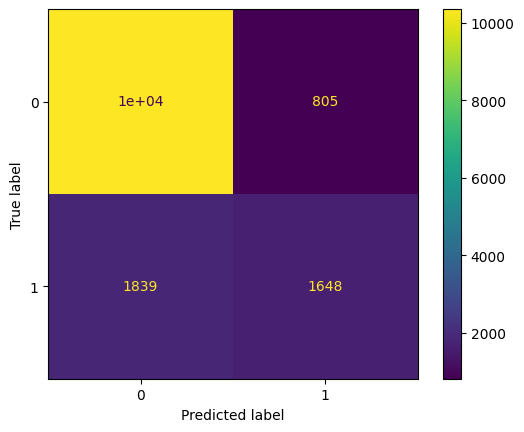

In [83]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot()
plt.show()

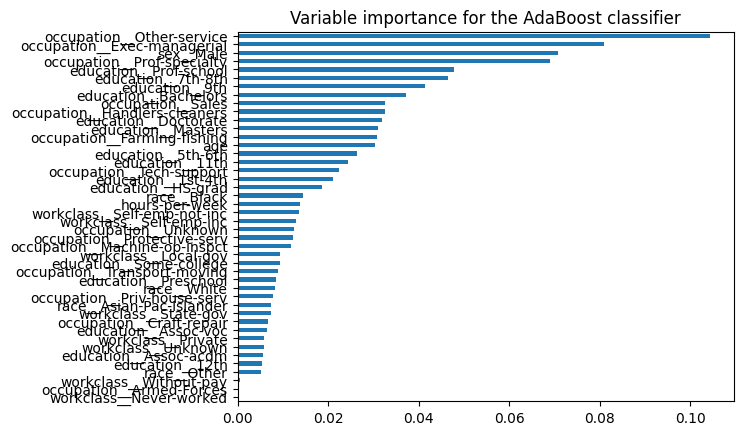

In [ ]:
# Collecting the feature importances
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plotting the feature importances
feature_importances.plot.barh()
plt.title("Variable importance for the AdaBoost classifier")
plt.show()

**Looking at this visualization of feature importance we see that sex had the third highest impact on the models prediction, being more important than a lot educations and occupations.**

7. To be able to calculate the various fairness metrics in regard to the variable `sex`, we need to construct two separate confusion matrices for the test dataset, one for `female` and one for `male`. First, create separate test sets for `female` and `male` as well as the predicted values for each gender. That is, create `X_test_female`, `X_test_male`, `y_test_female`, `y_test_male`, `y_pred_female`, and `y_pred_male`. (Hint: You can create `X_test_female` by `X_test_female = X_test[X_test["sex_Male"] == 0]` and `y_test_male` by `y_test_male = y_test[X_test["sex_Male"] == 1]`, for instance.)

In [88]:
X_test_female = X_test[X_test["sex__Male"] == 0]
y_test_female = y_test[X_test["sex__Male"] == 0]
X_test_male = X_test[X_test["sex__Male"] == 1]
y_test_male = y_test[X_test["sex__Male"] == 1]

8. Calculate the accuracy for female and male for the XGBoost model and comment on the results.

In [ ]:
#accuracy for female for the XGBoost model
y_pred_test_female = xgb_model.predict(X_test_female)
accuracy_female=accuracy_score(y_test_female, y_pred_test_female)
print("Accuracy for female:", accuracy_female)

Accuracy: 0.8980222496909765


In [94]:
#accuracy for male for the XGBoost model
y_pred_test_male = xgb_model.predict(X_test_male)
accuracy_male=accuracy_score(y_test_male, y_pred_test_male)
print("Accuracy for male:", accuracy_male)

Accuracy for male: 0.7806919073374834


In [95]:
accuracy_female-accuracy_male

0.11733034235349316

* After Calculating the accuracy for females and males for the XGBoost model, we can say that the model predicts much better for females (12% better) than males. This means the model could be biased; otherwise, the accuracy difference should not be so big. To be precise, we need to perform more fairness metrics. 

9. We can now create the True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN) for each gender. That is, calculate the eight values `TP_f`, `TN_f`, `FP_f`, `FN_f`, `TP_m`, `TN_m`, `FP_m`, and `FN_m`. (Hint: You can calculate the False Positive for female (FP_f) by `FP_f = sum((y_test_female == 0) & (y_pred_female == 1))`.)

In [101]:
TP_f = sum((y_test_female == 1) & (y_pred_test_female == 1))
FP_f = sum((y_test_female == 0) & (y_pred_test_female == 1))
TN_f = sum((y_test_female == 0) & (y_pred_test_female == 0))
FN_f = sum((y_test_female == 1) & (y_pred_test_female == 0))
print('True_Positive_Female:'+str(TP_f))
print('False_Positive_Female:'+str(FP_f))
print('True_Negative_Female:'+str(TN_f))
print('False_Negative_Female:'+str(FN_f))

True_Positive_Female:56
False_Positive_Female:67
True_Negative_Female:4303
False_Negative_Female:428


In [102]:
TP_m = sum((y_test_male == 1) & (y_pred_test_male == 1))
FP_m = sum((y_test_male == 0) & (y_pred_test_male == 1))
TN_m = sum((y_test_male == 0) & (y_pred_test_male == 0))
FN_m = sum((y_test_male == 1) & (y_pred_test_male == 0))
print('True_Positive_Male:'+str(TP_m))
print('False_Positive_Male:'+str(FP_m))
print('True_Negative_Male:'+str(TN_m))
print('False_Negative_Male:'+str(FN_m))

True_Positive_Male:1592
False_Positive_Male:738
True_Negative_Male:6058
False_Negative_Male:1411


10. Is there error rate balance across different genders, i.e. are the false positive rate (FPR) and false negative rate (FNR) the same across the two genders?

In [106]:
#False positive rate (FPR) [FP/(TN+FP)] 
FPR_female=FP_f/(TN_f+FP_f)
FNR_female=FN_f/(TP_f+FN_f)
FPR_male=FP_m/(TN_f+FP_m)
FNR_male=FN_m/(TP_f+FN_m)


In [107]:
error_rate_balance = max(abs(FPR_female - FPR_male), abs(FNR_female - FNR_male))
error_rate_balance

0.13106771612366694

* The error rates are not considered balanced(the value is to big). The difference in error rates is larger than what we're willing to accept. The model *does not* meet the Error Rate Balance criteria.

11. Is there predictive parity across different genders?

In [108]:
#Equalizing Positive predictive value (PPV)=[ TP/(FP+TP) ] 
PPV_f=TP_f/(FP_f+TP_f)
PPV_m=TP_m/(FP_m+TP_m)
print('PPV for Female : '+str(PPV_f))
print('PPV for Male : '+str(PPV_m))

PPV for Female : 0.45528455284552843
PPV for Male : 0.6832618025751073


* The Positive Predictive Value (PPV) for females is 45.5%, while the PPV for males is 68.3%. This represents a significant difference of 22.8 percentage points.So the model is less reliable at identifying truly high-earning potential among females.

12. Is there Statistical parity across different genders?

In [109]:
#Statistical (/demographic) parity: corresponds to equalizing (FP+TP)/(TP+FN+FP+TN) 
P_female = (TP_f + FP_f) / (TP_f + FP_f+TN_f + FN_f)
P_male = (TP_m + FP_m) / (TP_m + FP_m+TN_m + FN_m)

print('Parity for Female : '+str(P_female))
print('Parity for Male : '+str(P_male))

Parity for Female : 0.02533992583436341
Parity for Male : 0.23777936524135115


* P_female is significantly lower than P_male, then we can say that the model is predicting "positive" less often for females (and therefore predicting "negative" more often for females).

13. [Discussion question] Can your any of your models be used to make fair salary predictions?
- No, because our model is trained on biased data the predictions will always be unfair.

14. [Discussion question] In what sense is the `adult` dataset biased (unfair)?
- Because the gender ratio is so unbalanced in the dataset it results in females being labelled as having a lower income. 

15. [Discussion question] If the dataset is biased, where could the bias potentially come from?
- There are two factors that can come in to play: firstly as mentioned above the ratio of male and female is not nearly equal. Second, if the data is based on historical data the data could also be unbiased from the fact that women used to get paid a less than men, resulting in a biased prediction, since the data is biased.   

16. [Optional] If you balance the number of males and females in the dataset (like we balanced the response variable in the Churn example), will you model become more fair?
- due to the nature of historical data mentioned above, this might not be the case.